In [5]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from spacy.lang.en.stop_words import STOP_WORDS

warnings.filterwarnings('ignore')

In [6]:
# Load the dataset 
df = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", error_bad_lines=False, encoding="ISO-8859-1")

In [7]:
# Display basic information about the dataset
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
          v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                               Unnamed: 2  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G o o d n i g h t . . .@"   
freq                                                    3   

                   Unnamed: 3 Unnamed: 4  
count            

In [8]:
# Amount of missing values
def missing_values(df, norows):   # input by the df and the number of rows that you want to show  
    total = df.isnull().sum().sort_values(ascending=False)  
    percent = ((df.isnull().sum().sort_values(ascending=False)/df.shape[0])*100).sort_values(ascending=False)  
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  
    return(missing_data.head(norows))  
  
missing_values(df,20) # we use the df and the number of rows to show is 20

,Total,Percent
Unnamed: 4,5566,99.892319
Unnamed: 3,5560,99.784637
Unnamed: 2,5522,99.102656
v1,0,0.000000
v2,0,0.000000


In [9]:
# Remove useless columns and rename v1 and v2 columns
df = df.rename(columns={"v1": "type", "v2": "message"})
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
# Visualize the distribution of spam and ham messages
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=df)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [10]:
# Change dtype of type column to category
df = df.astype({"type": "category"})

# Drop duplicates
df.drop_duplicates(inplace=True)

# Replace ham and spam by 0 and 1
df['type'] = df['type'].map({'ham': 0, 'spam': 1})

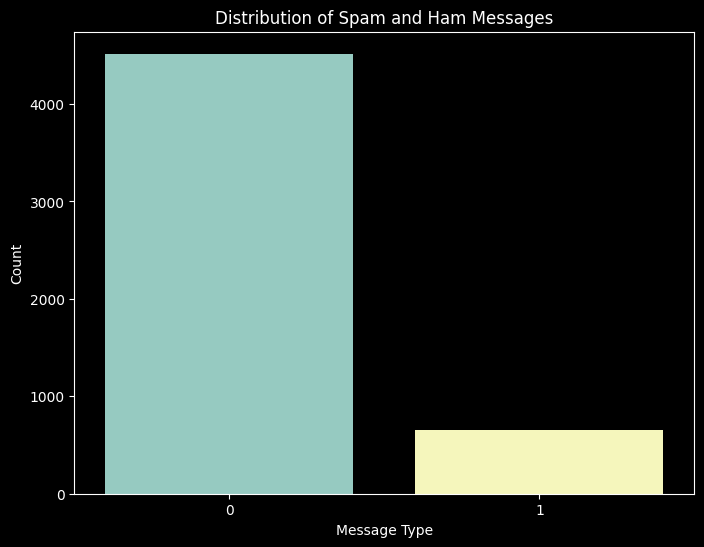

In [12]:
# Preprocessing - cleaning the text
nlp = spacy.load('en_core_web_md')

# Remove special characters, convert to lowercase, and lemmatize words
df['mail_cleaned'] = (
    df['message']
    .apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
    .str.lower()
    .str.strip()
    .str.replace('\s\s+', ' ')
    .apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
)

df.head()

,type,message,mail_cleaned
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live


In [13]:
# Tokenize the cleaned text
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(df.mail_cleaned)
df["mail_encoded"] = tokenizer.texts_to_sequences(df.mail_cleaned)
df.head()

,type,message,mail_cleaned,mail_encoded
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[1, 214, 409, 485, 845, 32, 52, 264, 846, 74, ..."
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[10, 176, 486, 265, 2, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 338, 3, 698, 699, 39, 1, 976, 458, 1, 1, ..."
3,0,U dun say so early hor... U c already then say...,u dun early hor u c,"[2, 114, 135, 1, 2, 78]"
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[662, 20, 597, 147]"


In [14]:
# Pad the sequences
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(df.mail_encoded, padding="post")

# Train-test split
xtrain, xval, ytrain, yval = train_test_split(messages_pad, df.type, test_size=0.3, random_state=42)

In [15]:
# Create tf.data datasets for training and validation
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-05 11:16:34.074141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 11:16:34.074752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Define the model architecture
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
    # Input Word Embedding layer
    tf.keras.layers.Embedding(vocab_size+1, 32, input_shape=[None,], name="embedding"),
    # Global average pooling
    tf.keras.layers.GlobalAveragePooling1D(),
    # Dense layer
    tf.keras.layers.Dense(16, activation='relu'),
    # Output layer
    tf.keras.layers.Dense(1, activation="sigmoid")  # changed activation to sigmoid for binary classification
])

# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Define the tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model with early stopping and tensorboard callbacks
history = model.fit(
    train_batch,
    epochs=100,
    validation_data=val_batch,
    callbacks=[tensorboard_callback, early_stop]
)

Epoch 1/100


2023-04-05 11:16:34.621088: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-05 11:16:34.622659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - ETA: 0s - loss: 0.6478 - binary_accuracy: 0.8416

2023-04-05 11:16:36.735602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 3s 31ms/step - loss: 0.6478 - binary_accuracy: 0.8416 - val_loss: 0.5903 - val_binary_accuracy: 0.8582
Epoch 2/100
57/57 [==============================] - 1s 23ms/step - loss: 0.5067 - binary_accuracy: 0.8803 - val_loss: 0.4505 - val_binary_accuracy: 0.8582
Epoch 3/100
57/57 [==============================] - 1s 21ms/step - loss: 0.3837 - binary_accuracy: 0.8803 - val_loss: 0.3848 - val_binary_accuracy: 0.8582
Epoch 4/100
57/57 [==============================] - 1s 22ms/step - loss: 0.3401 - binary_accuracy: 0.8803 - val_loss: 0.3725 - val_binary_accuracy: 0.8582
Epoch 5/100
57/57 [==============================] - 1s 23ms/step - loss: 0.3284 - binary_accuracy: 0.8803 - val_loss: 0.3638 - val_binary_accuracy: 0.8582
Epoch 6/100
57/57 [==============================] - 1s 24ms/step - loss: 0.3194 - binary_accuracy: 0.8803 - val_loss: 0.3545 - val_binary_accuracy: 0.8582
Epoch 7/100
57/57 [==============================] - 1s 21ms/step - loss: 0.

In [18]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_batch)
print("Validation loss: ", val_loss)
print("Validation accuracy: ", val_accuracy)

25/25 [==============================] - 0s 5ms/step - loss: 0.0663 - binary_accuracy: 0.9819
Validation loss:  0.06627298146486282
Validation accuracy:  0.9819471836090088


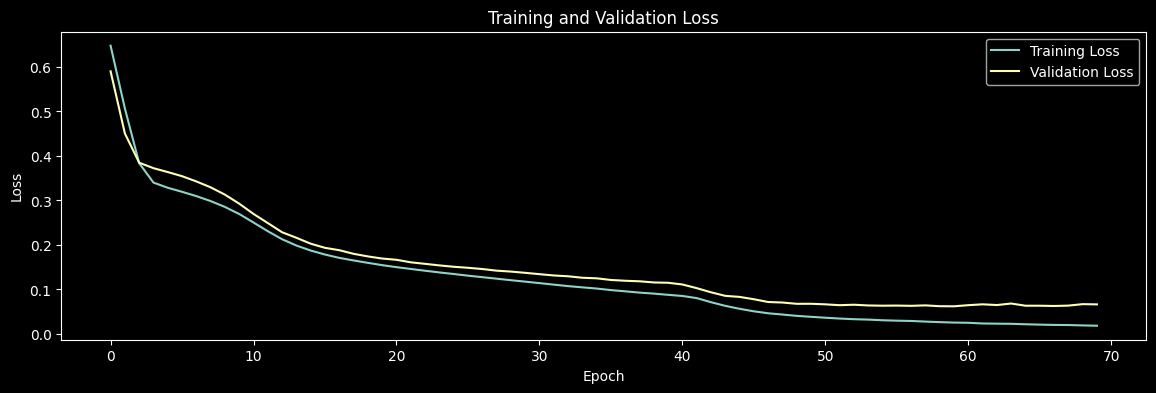

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

plt.show()

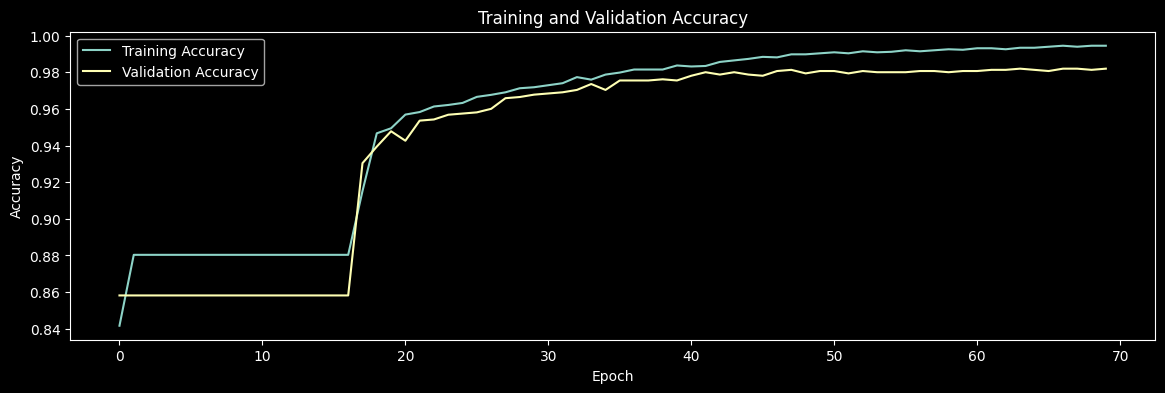

In [28]:
fig, ax2 = plt.subplots(1, 1, figsize=(14, 4))

# Plot training and validation accuracy
ax2.plot(history.history['binary_accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

49/49 [==============================] - 0s 3ms/step


2023-04-05 11:29:09.776612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


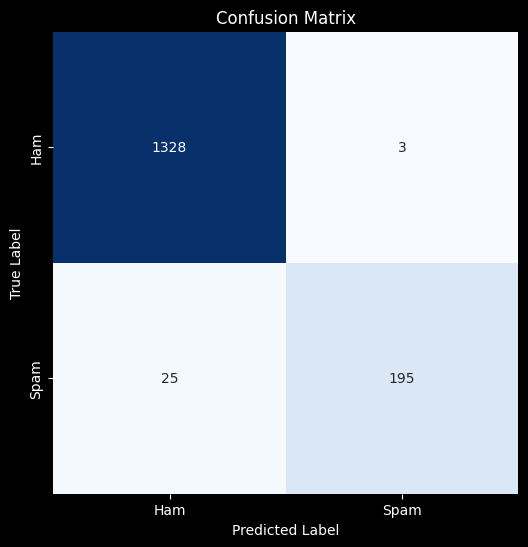

In [30]:
# Predict the probabilities on the validation set
y_pred_probs = model.predict(xval)

# Apply a threshold (0.5) to obtain class labels
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(yval, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Ham', 'Spam'])
plt.yticks([0.5, 1.5], ['Ham', 'Spam'], va='center')
plt.show()